# Statistic Analysis

#### Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, hour, weekofyear, dayofweek
import scipy
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pandas as pd


#### Load Data

In [2]:
# Create spark session
spark = SparkSession.builder \
    .appName("Statistic analysis") \
    .getOrCreate()

# Load data from csv file
df_yearly_prices = spark.read.csv("../../data/df_yearly_prices.csv", header=True, inferSchema=True)


#### Descriptive Statistics

In [3]:
# Mean, standard deviation, min, max, count
df_yearly_prices.describe().show()

+-------+-----------------+----------+
|summary|            value|percentage|
+-------+-----------------+----------+
|  count|             8589|      8589|
|   mean|164.2316427989284|       1.0|
| stddev|68.13322604896808|       0.0|
|    min|            11.68|         1|
|    max|           474.37|         1|
+-------+-----------------+----------+



In [4]:
# Quantile 0.25, 0.5, 0.75
df_yearly_prices.approxQuantile("value", [0.25, 0.5, 0.75], 0.0)

[124.48, 159.31, 200.59]

#### Data distribution

<Axes: >

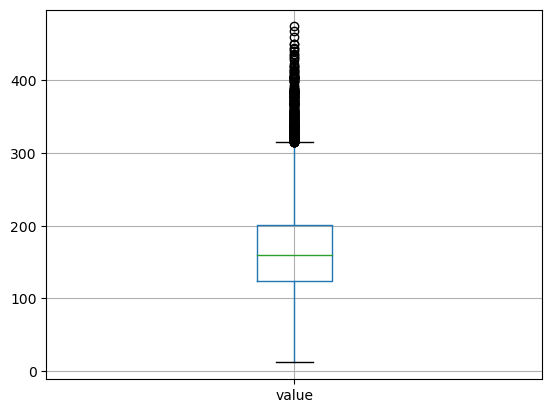

In [5]:
# boxplot
df_yearly_prices.select("value").toPandas().boxplot()

In [6]:
# outliers detection using dispersion method (IQR)
q1, q3 = df_yearly_prices.approxQuantile("value", [0.25, 0.75], 0.0)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_outliers = df_yearly_prices.filter((df_yearly_prices.value < lower_bound) | (df_yearly_prices.value > upper_bound))

# create a new dataframe without outliers
df_yearly_prices_no_outliers = df_yearly_prices.filter((df_yearly_prices.value >= lower_bound) & (df_yearly_prices.value <= upper_bound))

In [7]:
# convert to pandas dataframe and save to csv file
df_yearly_prices_no_outliers = df_yearly_prices_no_outliers.toPandas()
df_yearly_prices_no_outliers.to_csv("../../data/df_yearly_prices_no_outliers.csv", index=False)

c:\Users\Usuario\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


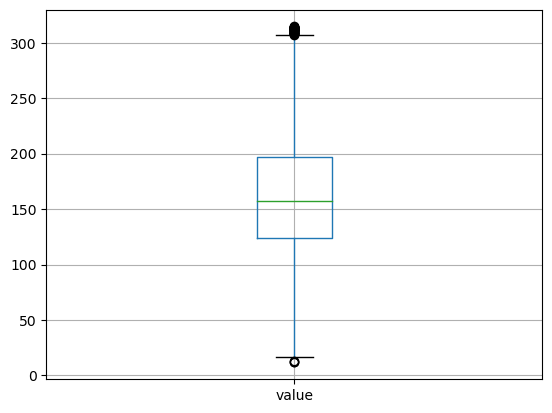

In [8]:
# boxplot without outliers
df_yearly_prices_no_outliers.boxplot()
plt.show()

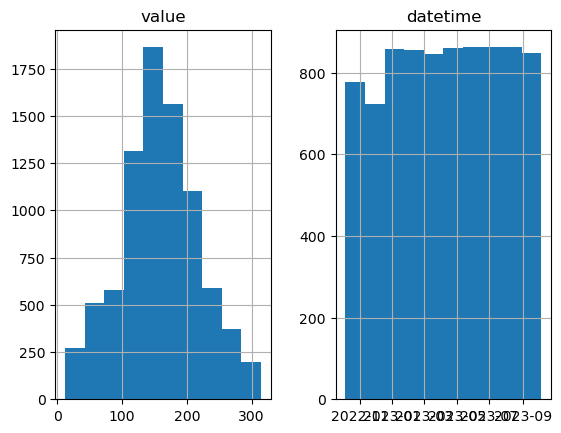

In [9]:
# density graph (histogram)
df_yearly_prices_no_outliers.hist()
plt.show()

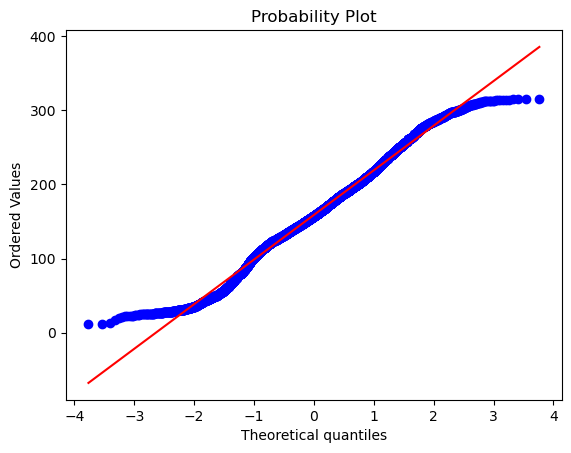

In [10]:
# P-P plot
scipy.stats.probplot(df_yearly_prices_no_outliers["value"], dist="norm", plot=plt)
plt.show()

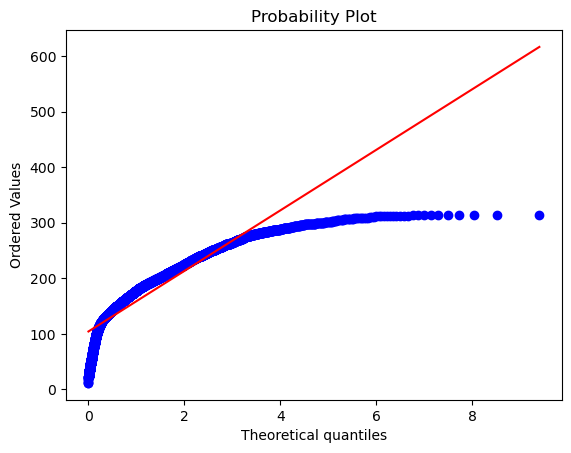

In [11]:
# exponential distribution
scipy.stats.probplot(df_yearly_prices_no_outliers["value"], dist="expon", plot=plt)
plt.show()



#### Correlation Analysis

In [12]:
# make new columns for year, month, week, day, weekday and hour with pandas
df_yearly_prices_no_outliers['year'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).year
df_yearly_prices_no_outliers['month'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).month
df_yearly_prices_no_outliers['week'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).week
df_yearly_prices_no_outliers['day'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).day
df_yearly_prices_no_outliers['weekday'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).weekday
df_yearly_prices_no_outliers['hour'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).hour

C:\Users\Usuario\AppData\Local\Temp\ipykernel_38688\126766346.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_yearly_prices_no_outliers['week'] = pd.DatetimeIndex(df_yearly_prices_no_outliers['datetime']).week


In [18]:
# convert to pandas dataframe and save to csv file
df_yearly_prices_extra = df_yearly_prices_no_outliers
df_yearly_prices_extra['datetime'] = pd.to_datetime(df_yearly_prices_extra['datetime'], utc=True)
df_yearly_prices_extra['datetime'] = df_yearly_prices_extra['datetime'].dt.tz_localize(None)


In [29]:
# save to csv file
df_yearly_prices_extra.to_csv("../../data/df_yearly_prices_extra.csv", index=False)

In [13]:
# correlation matrix graph with pandas
df_yearly_prices_extra = df_yearly_prices_extra.drop('datetime', axis=1)
df_yearly_prices_extra.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_38688\1926845739.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df_yearly_prices_extra.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,value,year,month,week,day,weekday,hour
value,1.00,-0.21,0.15,0.14,-0.10,-0.28,0.21
year,-0.21,1.00,-0.72,-0.72,-0.09,-0.03,0.02
month,0.15,-0.72,1.00,0.99,0.04,0.02,-0.01
week,0.14,-0.72,0.99,1.00,0.12,0.00,-0.01
day,-0.10,-0.09,0.04,0.12,1.00,-0.01,-0.03
weekday,-0.28,-0.03,0.02,0.00,-0.01,1.00,0.00
hour,0.21,0.02,-0.01,-0.01,-0.03,0.00,1.00


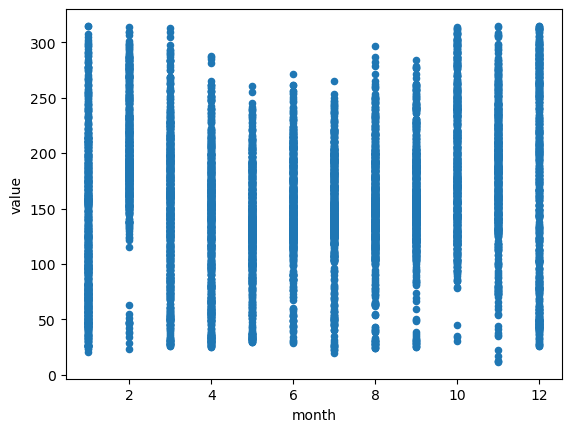

In [14]:
# dispersion graph with pandas
df_yearly_prices_extra.plot.scatter(x='month', y='value')
plt.show()